# Quantum Coinflip
The aim of this notebook is for me to get used to quantum circuits, qubits and IBM's Quantum Computing service.

In [17]:
import os
import numpy as np
import sys
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit.primitives import (BackendEstimatorV2, BackendSamplerV2)
from qiskit_aer.backends.compatibility import Statevector

## Hadamard Gate
To do a coinflip I want to place a single qubit $|\psi\rangle$ in an equal superposition of $|0\rangle$ and $|1\rangle$, so that when measured there is a 50-50 probability of being in either state. The way to do that is to apply a Hadamard gate to the initial state $|0\rangle$ so that $|\psi\rangle = |0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1|\rangle)$.

The Hadamard gate corresponds to a $\pi$ rotation around the X+Z axis, and has the effect of changing the computational basis:
$$
|0\rangle \leftrightarrow |+\rangle = \frac{1}{\sqrt(2)}(|0\rangle + |1\rangle),
$$
$$
|1\rangle \leftrightarrow |-\rangle = \frac{1}{\sqrt(2)}(|0\rangle - |1\rangle).
$$
A second Hadamard gate completes a $2\pi$ rotation, and changes the computational basis back. To perform a coinflip, the circuit needs to be a Hadamard gate on one qubit, followed by a measurement onto a classical register.

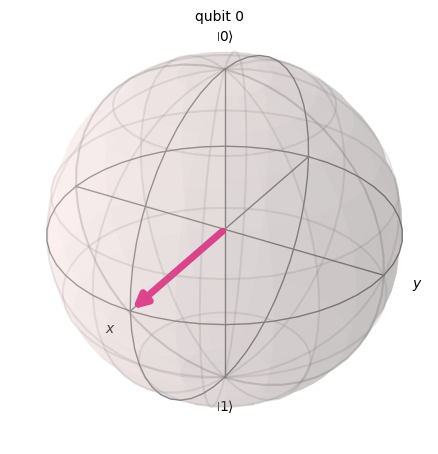

In [2]:
# create quantum circuit
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
Statevector(qc).draw('bloch')

On the Bloch sphere the qubit is placed equally between $|0\rangle$ and $|1\rangle$ on the z-axis. So if we do this a number of times, measuring the qubit on the z-axis, we should get an equal number of 'head' and 'tails' (0 and 1). I will simulate a backend for now, just to make sure everything is working.

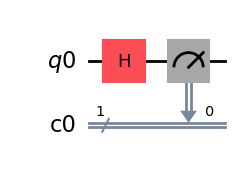

In [3]:
# measure
qc.measure(q0, c0)
qc.draw('mpl')

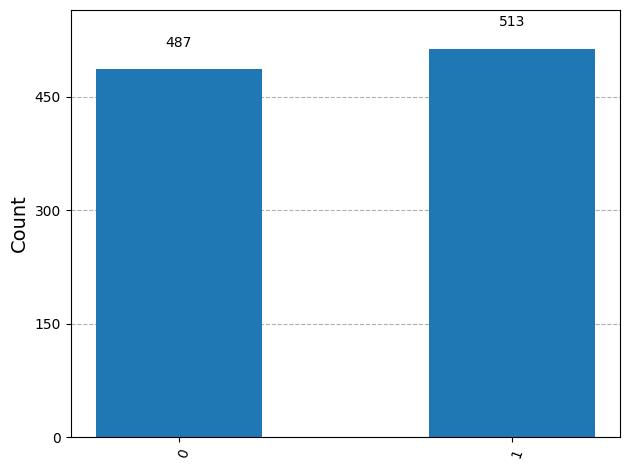

In [4]:
# Run a quick test of the circuit on a simulated backend.
backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, backend)
job = backend.run(qc, shots=1000)
result = job.result().get_counts()
plot_histogram(result)

Success! Over 1000 simulations of the circuit, we get roughly balanced outcomes of 0 and 1.

If we apply another Hadamard gate before measuring, we should change the basis back to $|0\rangle$. Let's check this works.

$$|0\rangle \rightarrow_H |+\rangle \rightarrow_H |0\rangle$$

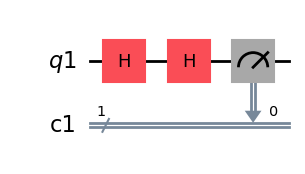

In [5]:
# Generate a new circuit with two hadamard gates.
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
qc.h(q0)
qc.measure(q0,c0)
qc.draw('mpl')

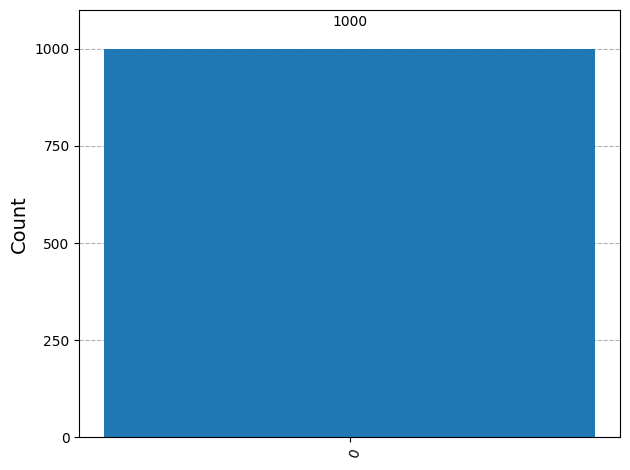

In [6]:
qc = transpile(qc, backend)
job = backend.run(qc, shots=1000)
result = job.result().get_counts()
plot_histogram(result)

## Connecting to IBM's backend
Now I want to run this basic circuit on real hardware. Qiskit's documentation make this a relatively painless process. I will do the following:
  - Connect to IBM's quantum service using my API, and instance CRN.
  - Pick backend hardware to use, ideally the least busy open quantum computer.
  - Reframe circuit so that it can be used by the backend.
  - Run circuit on backend.

I built a separate Script **`imbq_connect.py`** to connect to IBM's runtime service, just because I thought I would be using it quite a lot. It connects me to the least busy service. I fetch my API token and instance separately as I need them to query data from the service down the line.

In [7]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [8]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-13 12:56:05,857: Loading account with the given token. A saved account will not be used.


Name: ibm_marrakesh
Version: 2
No. of qubits: 156



# Executing Circuit on Backend
To run the coinflip circuit on the backend, we need to transpile it into something a quantum computer can execute. Qiskit has a handy transpiler, doing all the work for us, with varying choice of optimisation.

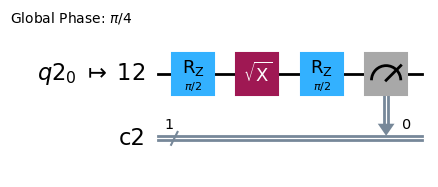

In [9]:
# create quantum circuit
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
qc.measure(q0, c0)

# Transpile circuit into something interpretable by the chosen quantum backend
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3) # this is the transpiler
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

Above is the transpiled circuit. A phase rotation of $\pi/2$, followed by a Sqrt(X) gate, and another $\pi/2$ rotation.

The Sqrt(X) gate is a half-NOT gate - applying this twice would get the single NOT gate. So I think we can think of the Sqrt(X) as a rotation of $\pi/2$ around the x-axis, much like half flipping a coin so that it stands on it's side.

# Primitives
Below is the execution of the circuit on the connected backend. There seem to be two main ways of executing a quantum circuit on hardware, the Sampler and Estimator primitives. My understanding from general computing ideas is that primitives are a high-abstraction interfaces that allow us to do what we want without getting bogged down in the nitty gritty. In this case they let us run a circuit and yield results without worrying about error correction, decoherence, interference etc.

## Sampler
The Sampler primitive runs the circuit and samples the results on classical registers. My main goal at the moment is to simply count the number of times the circuit returns 0 and 1, so this seems appropriate.

In [ ]:
# ## Run sample 1000 times on hardware
# sampler = Sampler(mode=backend)
# pubs = [qc_isa]
# job = sampler.run(pubs, shots=1000)
# res = job.result()

To save computation time on the service, I can fetch the results instead of waiting in a queue again.

In [28]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45c4bd63mfc73a6rqs0')
job_result = job.result()

qiskit_runtime_service._discover_account:WARNING:2025-11-06 23:48:18,834: Loading account with the given token. A saved account will not be used.


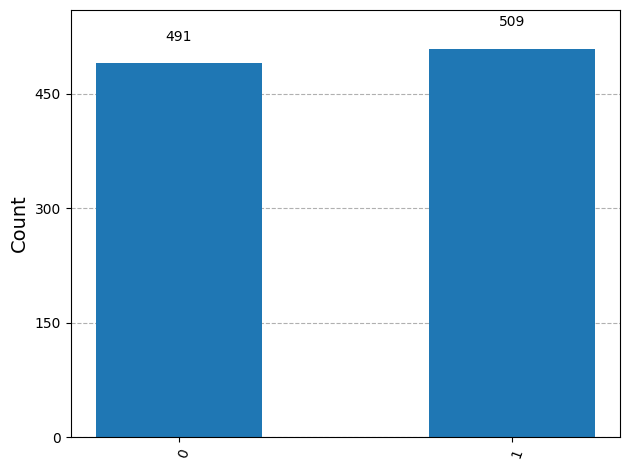

In [29]:
# Plot histogram of resulting states.
pub_result = job_result[0].data.c1.get_counts()
plot_histogram(pub_result)

On real hardware we still get an even split, up to some statistical fluctuation.

## Estimator
An estimator calculates the expected value of an observable with respect to a quantum state. We sample by measuring in the z-basis, so it seems natural to try an estimate in that basis also. For this I will use the Pauli '$Z$' matrix. The expected value of this is:

$$ E(Z) = \langle \psi | Z | \psi \rangle = \frac{1}{2} \langle 0 | Z | 0 \rangle + \frac{1}{2} \langle 1 | Z | 1 \rangle = \frac{1}{2}(+1) + \frac{1}{2}(-1) = 0$$.


In [10]:
# Create coinflip circuit. No measuring needed so no classical register.
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)

# Transpile
obs = Pauli('Z')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

In [11]:
print('Simulated E[Z] = ', res[0].data.evs)

Simulated E[Z] =  -0.00634765625


Gives a good result on the simulator, so try on the real deal. 

In [ ]:
## Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [12]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45p8l6n7jjs73bst07g')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-13 13:04:34,989: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: -0.000493339911198816


Great! This was the expected result: the coinflip is expected to be 50-50 when estimating observable $Z$.

## Estimating in Other Basis.
Since the Hadamard gate is a rotation around the X+Z axis, I want to try estimating in the X axis as an alternative. For this I will use the Pauli X (NOT) gate. On the IBM qiskit learning site, they describe this as estimating 'heads left or right' rather than 'heads up or down'. The NOT gate applied to the new computational basis states gives

$$X|+\rangle = |+\rangle \implies \langle+|X|+\rangle = \langle+||+\rangle = +1$$
$$X|-\rangle = -|-\rangle \implies \langle-|X|-\rangle = -\langle-||-\rangle = -1$$

If $|\psi\rangle$ is equally placed between these states I would expect a value of 0.

In [13]:
# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

In [ ]:
# # Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [14]:
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45rj7ejf4ms73ap36kg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-13 13:07:31,165: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: 1.0


This gives a value of 1 instead of 0. This is because the coinflip circuit first applies a Hadamard gate to $|0\rangle$ yielding $|+\rangle$, so we are not actually between the two new computational basis vectors. Since we are at $|+\rangle$, our EV is just from that basis, so we expect a value of +1.

So we get different results depending on how we measure the qubit. I think this gives a good idea on the depth of this system in comparison to a classical computer.

I think this result is mainly down to the phase of the qubit. If I phase rotate by $\pi/2$ around the Z-axis, the qubit should now be in the equal superposition of $|+\rangle$ and $|-\rangle$. Let's see.

In [18]:
# Create new coinflip circuit
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)
qc_e.p(np.pi/2, q_e)

# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

print('Simulated E[X] = ', res[0].data.evs)

Simulated E[X] =  0.0


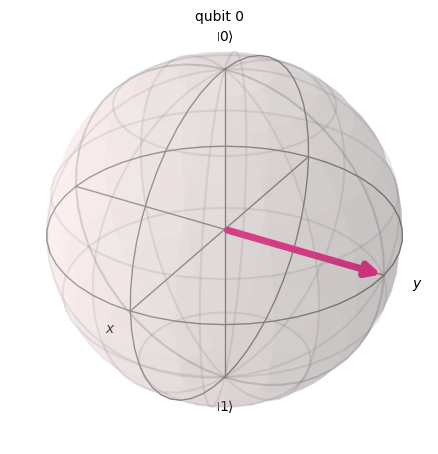

In [19]:
Statevector(qc_e).draw('bloch')

Looking at the Bloch Sphere, we can see that with the phase rotation the qubit is now 'balanced' in the x-axis and the z-axis, though not the y-axis. The measured expectation is 0 so the phase rotation has worked.

# Weighted Coinflip
I want to manipulate the amplitudes so that when measuring in the z-basis I have a biased 75:25 split.

This looks like $|\psi\rangle = \sqrt{0.75} |0\rangle + \sqrt{0.25} |1\rangle$. Trigonometry on the bloch sphere tells us $|\psi\rangle = cos \frac{\theta}{2} |0\rangle + e^{i\phi} sin \frac{\theta}{2} |1\rangle$. So we have

$$cos \theta/2 = \sqrt{3}/2,$$
$$sin \theta/2 = 1/2,$$

therefore $\theta = \pi/3$. Implementing this rotation inbetween two Hadamard gates should give the desired rotation around the y-axis. I will try this out:

In [20]:
# Create new coinflip circuit
q = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(q, cr)
qc.h(q)
qc.p(np.pi/3, q) # phase rotation of theta
qc.h(q)
qc.measure_all()

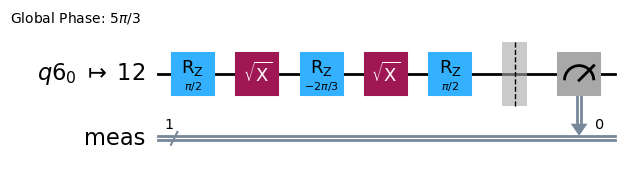

In [21]:
# Transpile
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

In [22]:
backend_sim = AerSimulator.from_backend(backend)
sampler_sim = BackendSamplerV2(backend=backend_sim)
job = sampler_sim.run([[qc_isa]], shots = 1000)
res = job.result()
# counts=job.result()[0].data.meas.get_counts()

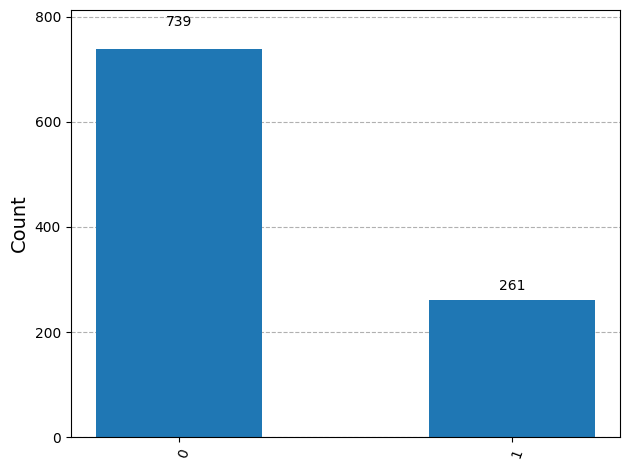

In [23]:
plot_histogram(res[0].data.meas.get_counts())

Success!